<a href="https://colab.research.google.com/github/shahidzk1/Machine_learning/blob/Development/Flowers_Images_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# The following packages are required for this notebook but they are not pre-installed on colab
%%capture
!pip install optuna
!pip install optuna-integration
!git clone -b Development https://github.com/shahidzk1/Machine_learning.git
%cd Machine_learning
!git pull origin main
!pip install -r requirements.txt
!python setup.py install

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL  #shows images inside the notebook
import pathlib  #converts path to PC path object
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import optuna
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
import gc


from sklearn.model_selection import train_test_split
from src.HP_OPT_class import HP_OPT_class_code

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='./flowers', untar=True)  #flower photos dir name, . current wd
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 [==============================] - 2s 0us/step


In [4]:
data_dir

'/tmp/.keras/datasets/flower_photos'

In [5]:
!ls flowers/datasets/flower_photos

ls: cannot access 'flowers/datasets/flower_photos': No such file or directory


In [6]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/tmp/.keras/datasets/flower_photos')

In [7]:
list(data_dir.glob('*/*.jpg'))[:10]

[PosixPath('/tmp/.keras/datasets/flower_photos/tulips/8712244311_da8e90bf8e_n.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/130685245_dcdd23836f_m.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/9444202147_405290415b_n.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/5891485349_cce7b99549.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/12557176134_ecbf15885b.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/5811022098_2523ca4e82.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/12949131454_4d3392f4dd_n.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/7205145492_baec4dbb94.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/2280950463_86510c2789_n.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/tulips/14487762578_baba13d16a_m.jpg')]

In [8]:
#to select only roses and put the paths in an array
roses = list(data_dir.glob('roses/*'))
roses[:3]

[PosixPath('/tmp/.keras/datasets/flower_photos/roses/3713368809_eba7fa2fbf_m.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/roses/2535466393_6556afeb2f_m.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/roses/20409866779_ac473f55e0_m.jpg')]

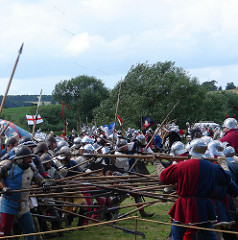

In [9]:
PIL.Image.open(str(roses[0]))

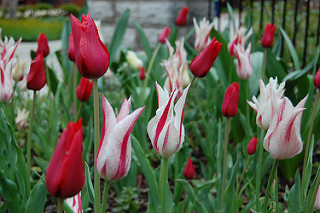

In [10]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [11]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [12]:
flowers_images_dict['roses'][0:3]

[PosixPath('/tmp/.keras/datasets/flower_photos/roses/3713368809_eba7fa2fbf_m.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/roses/2535466393_6556afeb2f_m.jpg'),
 PosixPath('/tmp/.keras/datasets/flower_photos/roses/20409866779_ac473f55e0_m.jpg')]

In [13]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 238, 3)

In [14]:
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(240, 240, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [15]:
X = []
y = []

for flower_category, image_paths in flowers_images_dict.items():
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(240, 240))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        augmented_img_array = data_augmentation(img_array)
        augmented_img_array /= 255.0
        X.append(augmented_img_array[0])
        label = flowers_labels_dict[flower_category]
        y.append(label)
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.9, random_state=42, stratify=y_train)

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [18]:
clear_session()
gc.collect()

0

In [19]:
if __name__ == "__main__":
    BATCHSIZE = 32
    cnn_hyperparameters = {
        'filters': [16, 64],
        'kernel_size': [3, 5],
        'n_conv_layers_min': 1,
        'n_conv_layers_max': 4,
        'dropout_min': 0.0,
        'dropout_max': 0.5,
    }
    optimizer = HP_OPT_class_code.HPOpt(X_train, y_train, batch_size=BATCHSIZE, n_trials=10,
                                        cnn_hyp_par=cnn_hyperparameters,
                                        num_classes=len(np.unique(y_train)))
    study_cnn = optimizer.optimize("cnn_image")

[I 2024-01-30 15:11:35,142] A new study created in memory with name: no-name-45a36fe6-002b-4aff-a451-6480b18c8241


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 8s 262ms/step - loss: 3.7212 - accuracy: 0.2094 - val_loss: 1.6173 - val_accuracy: 0.1695
Epoch 2/10
8/8 [==============================] - 1s 101ms/step - loss: 1.6138 - accuracy: 0.2009 - val_loss: 1.6098 - val_accuracy: 0.1695
Epoch 3/10
8/8 [==============================] - 1s 102ms/step - loss: 1.6059 - accuracy: 0.2222 - val_loss: 1.6087 - val_accuracy: 0.2203
Epoch 4/10
8/8 [==============================] - 1s 111ms/step - loss: 1.5843 - accuracy: 0.2863 - val_loss: 1.5760 - val_accuracy: 0.3390
Epoch 5/10
8/8 [==============================] - 1s 111ms/step - loss: 1.5370 - accuracy: 0.3248 - val_loss: 1.5168 - val_accuracy: 0.3729
Epoch 6/10
8/8 [==============================] - 1s 99ms/step - loss: 1.4381 - accuracy: 0.4060 - val_loss: 1.4139 - val_accuracy: 0.4068
Epoch 7/10
8/8 [==============================] - 1s 100ms/step - loss: 1.2947 - accuracy: 0.4701 - val_loss: 1.3597 - val_accuracy: 0.4237
Epoch 8/10
8/8 [================

[I 2024-01-30 15:11:51,079] Trial 0 finished with value: 0.5762711763381958 and parameters: {'num_conv_layers': 3, 'num_filters': 49, 'kernel_size': 3, 'conv_dropout_rate': 0.31286218037786906}. Best is trial 0 with value: 0.5762711763381958.


Trial 0, Score: 0.5762711763381958
Parameters: {'num_conv_layers': 3, 'num_filters': 49, 'kernel_size': 3, 'conv_dropout_rate': 0.31286218037786906}
Epoch 1/10
8/8 [==============================] - 3s 205ms/step - loss: 6.1700 - accuracy: 0.2094 - val_loss: 2.6255 - val_accuracy: 0.2373
Epoch 2/10
8/8 [==============================] - 1s 93ms/step - loss: 1.7296 - accuracy: 0.3718 - val_loss: 1.4258 - val_accuracy: 0.3898
Epoch 3/10
8/8 [==============================] - 1s 91ms/step - loss: 1.4197 - accuracy: 0.3932 - val_loss: 1.4150 - val_accuracy: 0.3559
Epoch 4/10
8/8 [==============================] - 1s 98ms/step - loss: 1.3058 - accuracy: 0.4872 - val_loss: 1.3887 - val_accuracy: 0.3390
Epoch 5/10
8/8 [==============================] - 1s 104ms/step - loss: 1.1477 - accuracy: 0.5427 - val_loss: 1.3064 - val_accuracy: 0.3898
Epoch 6/10
8/8 [==============================] - 1s 93ms/step - loss: 0.9499 - accuracy: 0.6453 - val_loss: 1.2353 - val_accuracy: 0.5085
Epoch 7/10
8/8 

[I 2024-01-30 15:12:02,352] Trial 1 finished with value: 0.5932203531265259 and parameters: {'num_conv_layers': 2, 'num_filters': 51, 'kernel_size': 3, 'conv_dropout_rate': 0.38726607441928795}. Best is trial 1 with value: 0.5932203531265259.


Trial 1, Score: 0.5932203531265259
Parameters: {'num_conv_layers': 2, 'num_filters': 51, 'kernel_size': 3, 'conv_dropout_rate': 0.38726607441928795}
Epoch 1/10
8/8 [==============================] - 1s 48ms/step - loss: 130.4117 - accuracy: 0.2094 - val_loss: 61.1157 - val_accuracy: 0.1864
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 56.4175 - accuracy: 0.2393 - val_loss: 19.0667 - val_accuracy: 0.1864
Epoch 3/10
8/8 [==============================] - 0s 27ms/step - loss: 10.0576 - accuracy: 0.2393 - val_loss: 1.6444 - val_accuracy: 0.1525
Epoch 4/10
8/8 [==============================] - 0s 25ms/step - loss: 1.5928 - accuracy: 0.1752 - val_loss: 1.6096 - val_accuracy: 0.1525
Epoch 5/10
8/8 [==============================] - 0s 24ms/step - loss: 1.5767 - accuracy: 0.2436 - val_loss: 1.6095 - val_accuracy: 0.2203
Epoch 6/10
8/8 [==============================] - 0s 26ms/step - loss: 1.5952 - accuracy: 0.2393 - val_loss: 1.6093 - val_accuracy: 0.2203
Epoch 7/10


[I 2024-01-30 15:12:06,392] Trial 2 finished with value: 0.22033898532390594 and parameters: {'num_conv_layers': 1, 'num_filters': 54, 'kernel_size': 5, 'conv_dropout_rate': 0.49511901896335003}. Best is trial 1 with value: 0.5932203531265259.


Trial 2, Score: 0.22033898532390594
Parameters: {'num_conv_layers': 1, 'num_filters': 54, 'kernel_size': 5, 'conv_dropout_rate': 0.49511901896335003}
Epoch 1/10
8/8 [==============================] - 4s 270ms/step - loss: 8.9723 - accuracy: 0.2094 - val_loss: 2.0426 - val_accuracy: 0.2373
Epoch 2/10
8/8 [==============================] - 1s 115ms/step - loss: 1.8691 - accuracy: 0.2692 - val_loss: 1.5379 - val_accuracy: 0.3390
Epoch 3/10
8/8 [==============================] - 1s 112ms/step - loss: 1.5047 - accuracy: 0.3120 - val_loss: 1.4431 - val_accuracy: 0.4237
Epoch 4/10
8/8 [==============================] - 1s 108ms/step - loss: 1.4050 - accuracy: 0.3889 - val_loss: 1.4099 - val_accuracy: 0.3898
Epoch 5/10
8/8 [==============================] - 1s 107ms/step - loss: 1.3623 - accuracy: 0.3718 - val_loss: 1.3709 - val_accuracy: 0.4407
Epoch 6/10
8/8 [==============================] - 1s 107ms/step - loss: 1.2441 - accuracy: 0.4701 - val_loss: 1.3068 - val_accuracy: 0.4407
Epoch 7/10

[I 2024-01-30 15:12:19,584] Trial 3 finished with value: 0.4067796468734741 and parameters: {'num_conv_layers': 2, 'num_filters': 60, 'kernel_size': 3, 'conv_dropout_rate': 0.44315214935716896}. Best is trial 1 with value: 0.5932203531265259.


Trial 3, Score: 0.4067796468734741
Parameters: {'num_conv_layers': 2, 'num_filters': 60, 'kernel_size': 3, 'conv_dropout_rate': 0.44315214935716896}
Epoch 1/10
8/8 [==============================] - 2s 72ms/step - loss: 78.2362 - accuracy: 0.2265 - val_loss: 15.2090 - val_accuracy: 0.2712
Epoch 2/10
8/8 [==============================] - 0s 38ms/step - loss: 14.7712 - accuracy: 0.2179 - val_loss: 1.6869 - val_accuracy: 0.2542
Epoch 3/10
8/8 [==============================] - 0s 29ms/step - loss: 1.5556 - accuracy: 0.2350 - val_loss: 1.5751 - val_accuracy: 0.2542
Epoch 4/10
8/8 [==============================] - 0s 34ms/step - loss: 1.5555 - accuracy: 0.2564 - val_loss: 1.6376 - val_accuracy: 0.3220
Epoch 5/10
8/8 [==============================] - 0s 25ms/step - loss: 1.5302 - accuracy: 0.2906 - val_loss: 1.6212 - val_accuracy: 0.2542
Epoch 6/10
8/8 [==============================] - 0s 30ms/step - loss: 1.5304 - accuracy: 0.2735 - val_loss: 1.5671 - val_accuracy: 0.2542
Epoch 7/10
8/8

[I 2024-01-30 15:12:26,675] Trial 4 finished with value: 0.32203391194343567 and parameters: {'num_conv_layers': 1, 'num_filters': 25, 'kernel_size': 4, 'conv_dropout_rate': 0.31732041966598196}. Best is trial 1 with value: 0.5932203531265259.


Trial 4, Score: 0.32203391194343567
Parameters: {'num_conv_layers': 1, 'num_filters': 25, 'kernel_size': 4, 'conv_dropout_rate': 0.31732041966598196}
Epoch 1/10
8/8 [==============================] - 5s 265ms/step - loss: 1.7174 - accuracy: 0.2051 - val_loss: 1.6056 - val_accuracy: 0.1864
Epoch 2/10
8/8 [==============================] - 1s 103ms/step - loss: 1.5934 - accuracy: 0.2009 - val_loss: 1.5914 - val_accuracy: 0.2034
Epoch 3/10
8/8 [==============================] - 1s 102ms/step - loss: 1.5159 - accuracy: 0.3248 - val_loss: 1.4974 - val_accuracy: 0.3898
Epoch 4/10
8/8 [==============================] - 1s 103ms/step - loss: 1.4925 - accuracy: 0.3803 - val_loss: 1.4609 - val_accuracy: 0.4407
Epoch 5/10
8/8 [==============================] - 1s 97ms/step - loss: 1.3782 - accuracy: 0.4145 - val_loss: 1.4568 - val_accuracy: 0.2881
Epoch 6/10
8/8 [==============================] - 1s 94ms/step - loss: 1.2594 - accuracy: 0.4402 - val_loss: 1.2333 - val_accuracy: 0.4407
Epoch 7/10
8

[I 2024-01-30 15:12:39,726] Trial 5 finished with value: 0.508474588394165 and parameters: {'num_conv_layers': 4, 'num_filters': 46, 'kernel_size': 4, 'conv_dropout_rate': 0.1678683360839201}. Best is trial 1 with value: 0.5932203531265259.


Trial 5, Score: 0.508474588394165
Parameters: {'num_conv_layers': 4, 'num_filters': 46, 'kernel_size': 4, 'conv_dropout_rate': 0.1678683360839201}
Epoch 1/10
8/8 [==============================] - 4s 210ms/step - loss: 3.5094 - accuracy: 0.1966 - val_loss: 1.5985 - val_accuracy: 0.2712
Epoch 2/10
8/8 [==============================] - 0s 58ms/step - loss: 1.6036 - accuracy: 0.2521 - val_loss: 1.6095 - val_accuracy: 0.2034
Epoch 3/10
8/8 [==============================] - 0s 60ms/step - loss: 1.6034 - accuracy: 0.1966 - val_loss: 1.6093 - val_accuracy: 0.1525
Epoch 4/10
8/8 [==============================] - 0s 60ms/step - loss: 1.6038 - accuracy: 0.2607 - val_loss: 1.6092 - val_accuracy: 0.2881
Epoch 5/10
8/8 [==============================] - 0s 61ms/step - loss: 1.5982 - accuracy: 0.2137 - val_loss: 1.6090 - val_accuracy: 0.2712
Epoch 6/10
8/8 [==============================] - 0s 56ms/step - loss: 1.5859 - accuracy: 0.2692 - val_loss: 1.6068 - val_accuracy: 0.2712
Epoch 7/10
8/8 [==

[I 2024-01-30 15:12:48,646] Trial 6 finished with value: 0.4576271176338196 and parameters: {'num_conv_layers': 3, 'num_filters': 25, 'kernel_size': 4, 'conv_dropout_rate': 0.4620884539103031}. Best is trial 1 with value: 0.5932203531265259.


Trial 6, Score: 0.4576271176338196
Parameters: {'num_conv_layers': 3, 'num_filters': 25, 'kernel_size': 4, 'conv_dropout_rate': 0.4620884539103031}
Epoch 1/10
8/8 [==============================] - 5s 294ms/step - loss: 2.3823 - accuracy: 0.2137 - val_loss: 1.6061 - val_accuracy: 0.2712
Epoch 2/10
8/8 [==============================] - 1s 123ms/step - loss: 1.5704 - accuracy: 0.3248 - val_loss: 1.5595 - val_accuracy: 0.2373
Epoch 3/10
8/8 [==============================] - 1s 121ms/step - loss: 1.5237 - accuracy: 0.2607 - val_loss: 1.5182 - val_accuracy: 0.4237
Epoch 4/10
8/8 [==============================] - 1s 124ms/step - loss: 1.3701 - accuracy: 0.4145 - val_loss: 1.2987 - val_accuracy: 0.4237
Epoch 5/10
8/8 [==============================] - 1s 127ms/step - loss: 1.3255 - accuracy: 0.4060 - val_loss: 1.3849 - val_accuracy: 0.4068
Epoch 6/10
8/8 [==============================] - 1s 126ms/step - loss: 1.2527 - accuracy: 0.5085 - val_loss: 1.3079 - val_accuracy: 0.4407
Epoch 7/10
8

[I 2024-01-30 15:13:11,004] Trial 7 finished with value: 0.5254237055778503 and parameters: {'num_conv_layers': 3, 'num_filters': 61, 'kernel_size': 3, 'conv_dropout_rate': 0.3846654191258322}. Best is trial 1 with value: 0.5932203531265259.


Trial 7, Score: 0.5254237055778503
Parameters: {'num_conv_layers': 3, 'num_filters': 61, 'kernel_size': 3, 'conv_dropout_rate': 0.3846654191258322}
Epoch 1/10
8/8 [==============================] - 1s 53ms/step - loss: 73.6555 - accuracy: 0.2009 - val_loss: 38.3876 - val_accuracy: 0.2542
Epoch 2/10
8/8 [==============================] - 0s 26ms/step - loss: 36.6066 - accuracy: 0.2265 - val_loss: 18.3719 - val_accuracy: 0.3051
Epoch 3/10
8/8 [==============================] - 0s 25ms/step - loss: 10.1693 - accuracy: 0.2436 - val_loss: 1.5821 - val_accuracy: 0.1695
Epoch 4/10
8/8 [==============================] - 0s 25ms/step - loss: 1.5878 - accuracy: 0.1752 - val_loss: 1.6008 - val_accuracy: 0.1864
Epoch 5/10
8/8 [==============================] - 0s 25ms/step - loss: 1.6003 - accuracy: 0.1966 - val_loss: 1.6039 - val_accuracy: 0.1864
Epoch 6/10
8/8 [==============================] - 0s 30ms/step - loss: 1.6009 - accuracy: 0.1966 - val_loss: 1.6092 - val_accuracy: 0.1864
Epoch 7/10
8/

[I 2024-01-30 15:13:15,618] Trial 8 finished with value: 0.2711864411830902 and parameters: {'num_conv_layers': 1, 'num_filters': 44, 'kernel_size': 5, 'conv_dropout_rate': 0.35608725442621514}. Best is trial 1 with value: 0.5932203531265259.


Trial 8, Score: 0.2711864411830902
Parameters: {'num_conv_layers': 1, 'num_filters': 44, 'kernel_size': 5, 'conv_dropout_rate': 0.35608725442621514}
Epoch 1/10
8/8 [==============================] - 1s 54ms/step - loss: 80.0266 - accuracy: 0.2564 - val_loss: 40.8497 - val_accuracy: 0.1695
Epoch 2/10
8/8 [==============================] - 0s 30ms/step - loss: 34.0250 - accuracy: 0.2692 - val_loss: 21.5463 - val_accuracy: 0.3390
Epoch 3/10
8/8 [==============================] - 0s 30ms/step - loss: 18.0835 - accuracy: 0.3803 - val_loss: 13.5332 - val_accuracy: 0.3220
Epoch 4/10
8/8 [==============================] - 0s 30ms/step - loss: 9.4987 - accuracy: 0.5256 - val_loss: 10.2533 - val_accuracy: 0.3898
Epoch 5/10
8/8 [==============================] - 0s 26ms/step - loss: 8.4742 - accuracy: 0.4744 - val_loss: 10.5659 - val_accuracy: 0.3390
Epoch 6/10
8/8 [==============================] - 0s 24ms/step - loss: 7.6985 - accuracy: 0.5726 - val_loss: 11.3785 - val_accuracy: 0.3390
Epoch 7/

[I 2024-01-30 15:13:19,942] Trial 9 finished with value: 0.33898305892944336 and parameters: {'num_conv_layers': 1, 'num_filters': 21, 'kernel_size': 5, 'conv_dropout_rate': 0.04385394083370092}. Best is trial 1 with value: 0.5932203531265259.


Trial 9, Score: 0.33898305892944336
Parameters: {'num_conv_layers': 1, 'num_filters': 21, 'kernel_size': 5, 'conv_dropout_rate': 0.04385394083370092}
CNN Best Trial:


In [21]:
clear_session()
gc.collect()
del study_cnn

In [ ]:
best_params= {'num_conv_layers': 3, 'num_filters': 53, 'kernel_size': 4, 'dropout_rate': 0.15522325561534278}

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

best_model = Sequential()

for i in range(best_params["num_conv_layers"]):
    if i == 0:
        best_model.add(
            Conv2D(
                filters=best_params["num_filters"],
                kernel_size=best_params["kernel_size"],
                activation="relu",
                input_shape=input_shape
            )
        )
        best_model.add(MaxPooling2D(pool_size=(2, 2)))
    else:
        best_model.add(
            Conv2D(
                filters=best_params["num_filters"],
                kernel_size=best_params["kernel_size"],
                activation="relu"
            )
        )
    best_model.add(MaxPooling2D(pool_size=(2, 2)))
    best_model.add(Dropout(best_params["dropout_rate"]))

best_model.add(Flatten())
best_model.add(Dense(128, activation='relu'))
best_model.add(Dropout(best_params["dropout_rate"]))
best_model.add(Dense(num_classes, activation='softmax'))
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


46/46 [==============================] - 8s 133ms/step - loss: 1.4979 - accuracy: 0.3086 - val_loss: 1.3501 - val_accuracy: 0.4360
Epoch 2/10
46/46 [==============================] - 5s 114ms/step - loss: 1.2293 - accuracy: 0.4666 - val_loss: 1.1703 - val_accuracy: 0.5422
Epoch 3/10
46/46 [==============================] - 5s 113ms/step - loss: 1.1400 - accuracy: 0.5109 - val_loss: 1.0727 - val_accuracy: 0.6104
Epoch 4/10
46/46 [==============================] - 5s 117ms/step - loss: 1.0569 - accuracy: 0.5722 - val_loss: 1.1165 - val_accuracy: 0.5940
Epoch 5/10
46/46 [==============================] - 5s 109ms/step - loss: 1.0134 - accuracy: 0.5920 - val_loss: 1.0109 - val_accuracy: 0.6049
Epoch 6/10
46/46 [==============================] - 5s 111ms/step - loss: 0.9468 - accuracy: 0.6322 - val_loss: 0.9272 - val_accuracy: 0.6403
Epoch 7/10
46/46 [==============================] - 6s 121ms/step - loss: 0.8381 - accuracy: 0.6751 - val_loss: 0.9025 - val_accuracy: 0.6567
Epoch 8/10
46/46 

In [ ]:
print(best_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 237, 237, 53)      2597      
                                                                 
 max_pooling2d (MaxPooling2  (None, 118, 118, 53)      0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 59, 59, 53)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 59, 59, 53)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 53)        44997     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 53)       

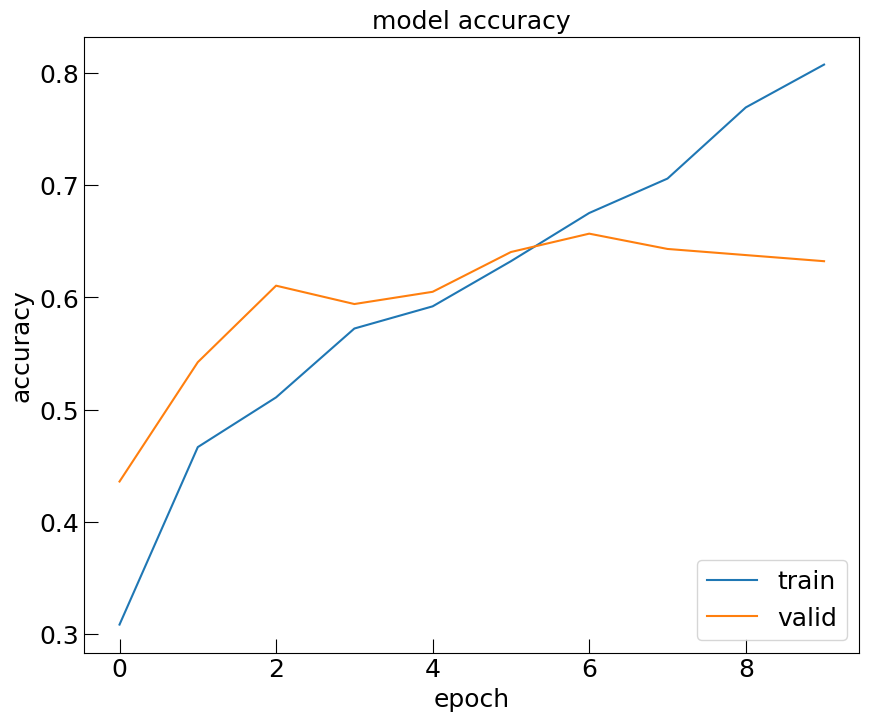

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('model accuracy', fontsize =18)
plt.ylabel('accuracy', fontsize =18)
plt.xlabel('epoch', fontsize =18)
plt.legend(loc="lower right",fontsize =18)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)

In [ ]:
clear_session()
gc.collect()

2769

In [ ]:
best_model.evaluate(X_val,y_val)

58/58 [==============================] - 2s 24ms/step - loss: 1.0739 - accuracy: 0.6365


[1.073892593383789, 0.636512279510498]

In [ ]:
pred = {0:'roses',
    1:'daisy',
    2:'dandelion',
    3:'sunflowers',
    4:'tulips'}

In [ ]:
import cv2
import numpy as np
img = cv2.imread(r'/tmp/.keras/datasets/flower_photos/tulips/4520577328_a94c11e806_n.jpg')
#cv2.imshow("flower",img)
print(img.shape)
img = cv2.resize(img,(240,240))
print(img.shape)
img = img.reshape(-1,240,240,3)
print(img.shape)
img = img/255
predictions = best_model.predict(img)
print("prediction is ",pred[np.argmax(predictions)])
cv2.waitKey(0)
cv2.destroyAllWindows()

(213, 320, 3)
(240, 240, 3)
(1, 240, 240, 3)
1/1 [==============================] - 0s 18ms/step
prediction is  tulips
